In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from cdrift import evaluation
from cdrift.utils.helpers import readCSV_Lists, convertToTimedelta
import numpy as np
from datetime import datetime
from statistics import mean, harmonic_mean, stdev
from typing import List
import seaborn as sns

LAG_WINDOW = 200

### Read the CSV and split by approach

In [2]:
df = readCSV_Lists("evaluation_results.csv")

##### Minor Preprocessing

In [3]:
# Rename Maaradji Runs to ProDrift
df["Algorithm"] = df["Algorithm"].replace("Maaradji Runs", "ProDrift")
df["Algorithm"].unique()

# Fill in the missing SW Step Size in Maaradji with 2
df.loc[df["Algorithm"] == "ProDrift", "SW Step Size"] = 2

In [4]:
df[df["Log Source"] == "Bose"]["Log"].unique()

array(['bose_log'], dtype=object)

##### Only use Atomic Logs

In [5]:
atomic_logs = {
    log
    for log in df["Log"].unique()
    if log.lower().startswith("atomic")
    or set(log.lower().split("_")[-1]) != {'i','o', 'r'}
    or log.lower().startswith("bose")
}

df = df[df["Log"].isin(atomic_logs)]
# df = df[(df["Log Source"] != "Ostovar") | (df["Log"].str.startswith("Atomic"))]
# df = df[(df["Log Source"] != "Ceravolo") | (df["Log"].isin(ceravolo_atomic_logs))]

In [6]:
def split_by_name(df):
    return [
        (alg, df[df["Algorithm"] == alg])
        for alg in df["Algorithm"].unique()
    ]

dfs = split_by_name(df)
df.Algorithm.unique()

for name, d in split_by_name(pd.read_csv("evaluation_results.csv")):
    print(f"{name} contains duplicate rows: {d.duplicated().any()}")

Process Graph Metrics contains duplicate rows: True
Martjushev ADWIN J contains duplicate rows: True
Martjushev ADWIN WC contains duplicate rows: True
Zheng DBSCAN contains duplicate rows: False
Maaradji Runs contains duplicate rows: False
Bose J contains duplicate rows: False
Bose WC contains duplicate rows: False
Earth Mover's Distance contains duplicate rows: False


In [7]:
df_csv = pd.read_csv("evaluation_results.csv")
df_m = df_csv[df_csv["Algorithm"] == "Martjushev ADWIN J"]
df_m[df_m.duplicated(keep=False)].sort_values(by=["Log", "Min Adaptive Window", "Max Adaptive Window", "Duration", "Detected Changepoints"])

,Algorithm,Log Source,Log,Min Adaptive Window,Max Adaptive Window,Detected Changepoints,Actual Changepoints for Log,F1-Score,Average Lag,Duration,P-Value,MRID,Epsilon,Window Size,SW Step Size
15667,Martjushev ADWIN J,Ostovar,Atomic_ConditionalRemoval_output_ConditionalRe...,400.0,400.0,[],"[999, 1999]",NaN,NaN,00:06:51,0.4,NaN,NaN,NaN,NaN
18401,Martjushev ADWIN J,Ostovar,Atomic_ConditionalRemoval_output_ConditionalRe...,400.0,400.0,[],"[999, 1999]",NaN,NaN,00:06:51,0.4,NaN,NaN,NaN,NaN
1313,Martjushev ADWIN J,Ostovar,Atomic_Frequency_output_Frequency,300.0,500.0,[499],"[999, 1999]",NaN,NaN,00:02:28,0.4,NaN,NaN,NaN,NaN
24888,Martjushev ADWIN J,Ostovar,Atomic_Frequency_output_Frequency,300.0,500.0,[499],"[999, 1999]",NaN,NaN,00:02:28,0.4,NaN,NaN,NaN,NaN
5844,Martjushev ADWIN J,Ostovar,Atomic_Frequency_output_Frequency_2,100.0,400.0,[],"[999, 1999]",NaN,NaN,00:03:46,0.4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26497,Martjushev ADWIN J,Ceravolo,sudden_trace_noise5_1000_sw,300.0,700.0,[],[499],NaN,NaN,00:00:09,0.4,NaN,NaN,NaN,NaN
14630,Martjushev ADWIN J,Ceravolo,sudden_trace_noise5_1000_sw,400.0,400.0,[],[499],NaN,NaN,00:00:07,0.4,NaN,NaN,NaN,NaN
26028,Martjushev ADWIN J,Ceravolo,sudden_trace_noise5_1000_sw,400.0,400.0,[],[499],NaN,NaN,00:00:07,0.4,NaN,NaN,NaN,NaN
1324,Martjushev ADWIN J,Ceravolo,sudden_trace_noise5_1000_sw,400.0,700.0,[],[499],NaN,NaN,00:00:06,0.4,NaN,NaN,NaN,NaN


### Split into noisy/noiseful logs

In [8]:
logs = zip(df["Log Source"], df["Log"])

noiseless_logs = {
    log for source, log in logs if 
    (source == "Ostovar"  and not (log.endswith("_2") or log.endswith("_5"))) or
    (source == "Ceravolo" and log.split("_")[2]=="noise0") or
    source == "Bose"
}

df_noiseless = df[df["Log"].isin(noiseless_logs)]
df_noisy = df[df["Log"].isin(noiseless_logs) == False]

dfs_noisy = split_by_name(df_noisy)
dfs_noiseless = split_by_name(df_noiseless)

## Accuracy
- All Change-Patterns
- Only 0 Noise
- Max cummulative *Recall* achieved of all parameter settings

In [10]:
df["Algorithm"].unique()

array(['Process Graph Metrics', 'Martjushev ADWIN J',
       'Martjushev ADWIN WC', 'Zheng DBSCAN', 'ProDrift', 'Bose J',
       'Bose WC', "Earth Mover's Distance"], dtype=object)

In [11]:
used_parameters = {
        "Bose J": ["Window Size", "SW Step Size"],
        "Bose WC": ["Window Size", "SW Step Size"],
        "Martjushev ADWIN J": ["Min Adaptive Window", "Max Adaptive Window", "P-Value"],
        "Martjushev ADWIN WC": ["Min Adaptive Window", "Max Adaptive Window", "P-Value"],
        "ProDrift": ["Window Size", "SW Step Size"],
        "Earth Mover's Distance": ["Window Size", "SW Step Size"],
        "Process Graph Metrics": ["Min Adaptive Window", "Max Adaptive Window"],
        "Zheng DBSCAN": ["MRID", "Epsilon"]
        # "Maaradji Runs": ["Window Size"],#, "SW Step Size"],
        # Forgot to write down PValue for Process Graph Metrics
        # "Process Graph Metrics": ["Min Adaptive Window", "Max Adaptive Window", "P-Value"],
        # Ignore PValue for now
    }



def calcAccuracy(df:pd.DataFrame, param_names:List[str], lag_window: int):
    """Calculates the Accuracy Metric for the given dataframe by grouping by the given parameters and calculating the mean accuracy

    Args:
        df (pd.DataFrame): _description_
        param_names (List[str]): _description_
        lag_window (int): _description_

    Returns:
        _type_: _description_
    """

    f1s = dict()
    recalls = dict()
    precisions = dict()
    # Group by parameter values to calculate accuracy per parameter setting, over all logs
    for parameters, group in df.groupby(by=param_names):
        # Calculate Accuracy for this parameter setting
        ## --> F1-Score, but first collect all TP and FP
        tps = 0
        fps = 0
        positives = 0
        detected = 0

        # Collect TP FP, etc. 
        for index, row in group.iterrows():
            actual_cp = row["Actual Changepoints for Log"]
            detected_cp = row["Detected Changepoints"]
            tp, fp = evaluation.getTP_FP(detected_cp, actual_cp, lag_window)
            tps += tp
            fps += fp
            positives += len(actual_cp)
            detected += len(detected_cp)

        try:
            precisions[parameters] = tps / detected
        except ZeroDivisionError:
            precisions[parameters] = np.NaN
        
        try:
            recalls[parameters] = tps / positives
        except ZeroDivisionError:
            recalls[parameters] = np.NaN

        f1s[parameters] = harmonic_mean([precisions[parameters], recalls[parameters]]) # If either is nan, the harmonic mean is nan
    return (precisions, recalls, f1s)

computed_accuracy_dicts = dict()
computed_precision_dicts = dict()
computed_recall_dicts = dict()

accuracy_best_param = dict()

accuracies = dict()
for name, a_df in dfs_noiseless:
    computed_precision_dicts[name], computed_recall_dicts[name], computed_accuracy_dicts[name] = calcAccuracy(a_df, used_parameters[name], LAG_WINDOW)

    best_param = max(computed_accuracy_dicts[name],  key=lambda x: computed_accuracy_dicts[name][x])

    accuracy_best_param[name] = best_param

    # accuracies[name] = max(computed_accuracy_dicts[name].values())
    accuracies[name] = computed_accuracy_dicts[name][best_param]
    print(f"{name}: {accuracies[name]}")

Martjushev ADWIN J: 0.7462686567164178
Martjushev ADWIN WC: 0
Process Graph Metrics: 0.7196969696969697
Earth Mover's Distance: 0.8333333333333334
Bose J: 0.7901234567901234
Bose WC: 0.7428571428571429
Zheng DBSCAN: 0.8641975308641975
ProDrift: 0.5964912280701754


#### Plot Accuracy as Barplot of Precision, Recall, F1

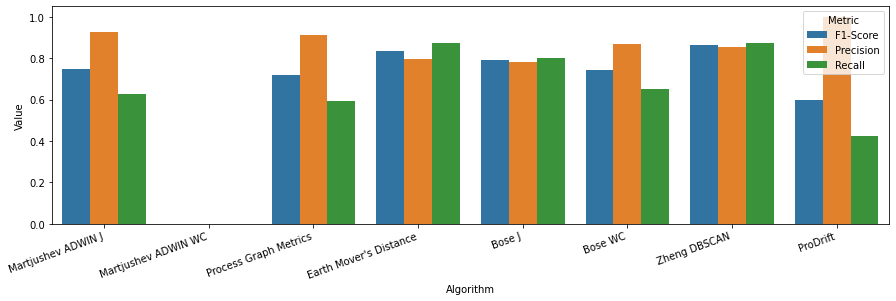

In [32]:
accuracy_plot_df = pd.DataFrame(
    [
        {
            "Algorithm": name,
            "Metric": "F1-Score",
            "Value": computed_accuracy_dicts[name][accuracy_best_param[name]]
        }
        for name in computed_accuracy_dicts.keys()
    ] + [
        {
            "Algorithm": name,
            "Metric": "Precision",
            "Value": computed_precision_dicts[name][accuracy_best_param[name]]
        }
        for name in computed_accuracy_dicts.keys()
    ] + [
        {
            "Algorithm": name,
            "Metric": "Recall",
            "Value": computed_recall_dicts[name][accuracy_best_param[name]]
        }
        for name in computed_accuracy_dicts.keys()
    ]
)
# accuracy_plot_df = pd.DataFrame([
#     {
#         "Algorithm": name,
#         "F1-Score": computed_accuracy_dicts[name][accuracy_best_param[name]],
#         "Precision": computed_precision_dicts[name][accuracy_best_param[name]],
#         "Recall": computed_recall_dicts[name][accuracy_best_param[name]]

#     }
#     for name in computed_accuracy_dicts.keys()
# ])

ax = sns.barplot(x="Algorithm", y="Value", data=accuracy_plot_df, hue="Metric") # Blueish
# palette = palette={"Precision": "#573deb", "F1-Score": "#ff0076", "Recall": "#ffa600"}

ax.figure.set_size_inches(15, 4)
# ax.tick_params(labelrotation=10, ha="right")
# Set each ticks horizontal alignment to "right"
for tick in ax.get_xticklabels():
    tick.set_ha("right")
    tick.set_rotation(20)
plt.show()

## Latency
- Using best parameter setting
- Same logs as above

In [41]:
from statistics import mean
def calcLatency(df, param_names, lag_window):
    latencies = dict()
    for parameters, group in df.groupby(by=param_names):
        # Calculate Accuracy for this parameter setting
        lags = []
        for index, row in group.iterrows():
            actual_cp = row["Actual Changepoints for Log"]
            detected_cp = row["Detected Changepoints"]
            assignments = evaluation.assign_changepoints(detected_cp, actual_cp)
            for d,a in assignments:
                lags.append(abs(d-a))
        if len(lags) != 0:
            # Scale Latency from 0 to 1
            avg_lag = 1-(mean(lags)/lag_window)
        else:
            avg_lag = np.NaN
        latencies[parameters] = avg_lag
    return latencies

computed_latency_dicts = dict()
latencies = dict()
for name, a_df in dfs_noiseless:
    result = calcLatency(a_df, used_parameters[name], LAG_WINDOW)
    computed_latency_dicts[name] = result
    latencies[name] = min(result.values())
    print(f"{name}: {(1-latencies[name])*200} Traces; Score: {latencies[name]}")

Process Graph Metrics: 97.16981132075473 Traces; Score: 0.5141509433962264
Martjushev ADWIN J: 86.97435897435896 Traces; Score: 0.5651282051282052
Martjushev ADWIN WC: nan Traces; Score: nan
Earth Mover's Distance: 56.1219512195122 Traces; Score: 0.719390243902439
Bose J: 65.08333333333334 Traces; Score: 0.6745833333333333
Bose WC: 92.3913043478261 Traces; Score: 0.5380434782608695
Zheng DBSCAN: 67.01751893939394 Traces; Score: 0.6649124053030303
ProDrift: 71.3529411764706 Traces; Score: 0.643235294117647


## Versatility

#### Preprocessing

In [22]:
mapping_ostovar_to_shortnames = {
    "ConditionalMove": 'cm',
    "ConditionalRemoval": 'cre',
    "ConditionalToSequence": 'cf',
    "Frequency": 'fr',
    "Loop": 'lp',
    "ParallelMove": 'pm',
    "ParallelRemoval": 'pre',
    "ParallelToSequence": 'pl',
    "SerialMove": 'sm',
    "SerialRemoval": 'sre',
    "Skip": 'cb',
    "Substitute": 'rp',
    "Swap": 'sw',
}

def map_row_to_cp(row):
    logname = row["Log"]
    if row["Log Source"] == "Ceravolo":
        return logname.split("_")[-1]
    elif row["Log Source"] == "Ostovar":
        return mapping_ostovar_to_shortnames[logname.split("_")[-1]]
    else:
        print("Whoopsie Daisy!")
        raise ValueError(f"Unknown Log Source for Versatility: {row['Log Source']}; Is this Log meant to be used for a Versatility Evaluation?")
# Only use the Ceravolo and Ostovar Logs as Bose has only 1 log with various change points
df_v = df_noiseless[df_noiseless["Log Source"].isin(["Ceravolo", "Ostovar"])].copy(deep=True)
# Add a column stating the change pattern that is applied
df_v["Change Pattern"] = df_v.apply(lambda x: map_row_to_cp(x), axis=1)

#### Calculation
- Recall of all logs of the same pattern, "concatenated", i.e., accumulate TP and FP first
- Divide this by the number of change patterns

In [26]:
versatility_recall_dicts = dict() # Map approach to a dictionary mapping a change pattern to the recall achieved by the approach on this change pattern
versatilities = dict() # Map approach to versatility score
for name, group in df_v.groupby(by=["Algorithm"]):
    recalls_of_this_approach = dict()
    for change_pattern, cp_group in group.groupby(by=["Change Pattern"]):
        TPS = 0
        POSITIVES = 0
        # TP / TP+FN = TP / POSTIVES = Recall
        for index, row in cp_group.iterrows():
            detected_changepoints = row["Detected Changepoints"]
            actual_changepoints = row["Actual Changepoints for Log"]

            tp, _ = evaluation.getTP_FP(detected_changepoints, actual_changepoints, LAG_WINDOW)

            TPS += tp
            POSITIVES += len(actual_changepoints)

        # Recall of this algorithm for this change pattern:
        recall = TPS / POSITIVES if POSITIVES != 0 else np.NaN # Only the case if there are no actual changepoints, which should not be the case
        recalls_of_this_approach[change_pattern] = recall
    versatility_recall_dicts[name] = recalls_of_this_approach
    versatilities[name] = mean(recalls_of_this_approach.values())
    print(f"{name}: {versatilities[name]}")


Bose J: 0.6059027777777778
Bose WC: 0.3767361111111111
Earth Mover's Distance: 0.7309027777777778
Martjushev ADWIN J: 0.5651041666666666
Martjushev ADWIN WC: 0.0
ProDrift: 0.2586805555555555
Process Graph Metrics: 0.5498046875
Zheng DBSCAN: 0.6875


#### Plot
- Barplot with "bar" for each change pattern and approach

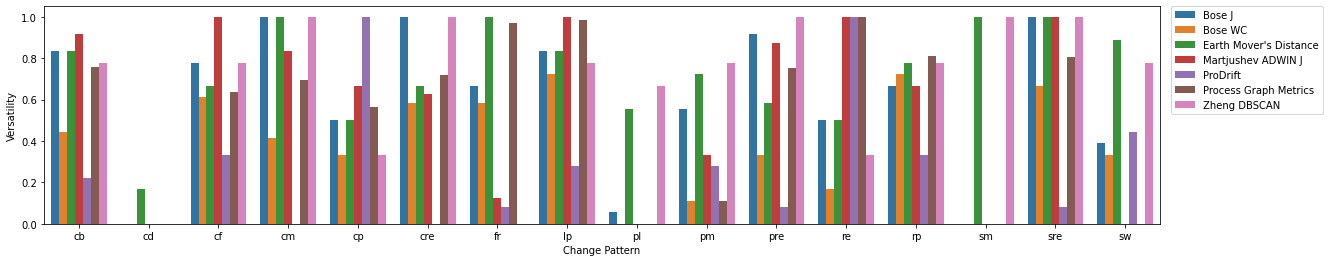

In [38]:
df_vers_plot = pd.DataFrame([
    {
        "Algorithm": name,
        "Change Pattern": cp,
        "Versatility": versatility_recall_dicts[name][cp]
    }
    for name in versatility_recall_dicts.keys()
    for cp in versatility_recall_dicts[name].keys()
])


fig,ax = plt.subplots(figsize=(20, 4))
sns.barplot(x="Change Pattern", y="Versatility", data=df_vers_plot, hue="Algorithm", ax=ax)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()

## Scalability
- Mean Duration
- Across ***all*** logs this time!

In [33]:
scalabilities = dict()
for name, a_df in dfs:
    result = a_df["Duration"].mean()
    result_str = datetime.strftime(datetime.utcfromtimestamp(result.seconds), '%H:%M:%S')
    scalabilities[name] = {"datetime": result, "str": result_str}
    print(f"{name}: {result_str}")

Process Graph Metrics: 00:00:29
Martjushev ADWIN J: 00:04:35
Martjushev ADWIN WC: 00:02:48
Zheng DBSCAN: 00:00:04
ProDrift: 00:04:44
Bose J: 00:12:59
Bose WC: 00:13:13
Earth Mover's Distance: 00:18:33


#### Plot Boxplot

<AxesSubplot:xlabel='Duration', ylabel='Algorithm'>

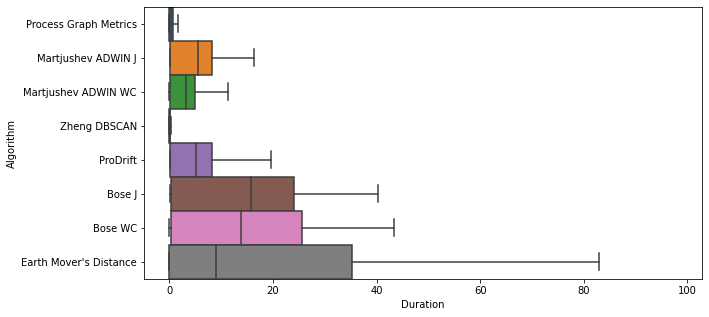

In [56]:
scalability_plot_df = pd.DataFrame([
    {
        "Algorithm": name,
        "Duration": duration.total_seconds() / 60
    }
    for name, a_df in dfs
    for duration in a_df["Duration"].tolist()
])

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("Duration [Minutes]")
sns.boxplot(data=scalability_plot_df, x="Duration", y="Algorithm", width=1, ax=ax, fliersize=0)

## Parameter Sensitivity
- For each Parameter setting, harmonic mean of *accuracy*, *latency*, and *versatility*
  - &rarr; Visualize the variance, etc., with a boxplot

In [ ]:
sensitivities = dict()
for name in df["Algorithm"].unique():
    _sensitivities = dict()
    acc = computed_accuracy_dicts[name]
    lat = computed_latency_dicts[name]
    vers = computed_versatility_dicts[name]
    for param_choice in acc.keys():
        sensitivity = harmonic_mean([acc[param_choice], lat[param_choice]])
        _sensitivities[param_choice] = sensitivity
    sensitivities[name] = _sensitivities


<AxesSubplot:xlabel='Observed Performances', ylabel='Algorithm'>

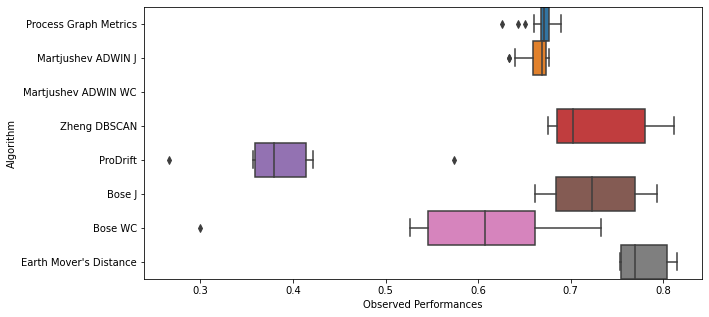

In [ ]:
sens_df = pd.DataFrame([
    {
        "Parameters": param,
        "Algorithm": name,
        "Observed Performances": sens
    }
    for name, sens_dict in sensitivities.items()
    for param, sens in sens_dict.items()
])
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=sens_df, x="Observed Performances", y="Algorithm", width=1, ax=ax)

In [ ]:
# Standard Deviation
print("Standard Deviations")

def try_calc_stdev(data):
    try:
        return stdev(data)
    except:
        return np.NaN

sensitivity_stds = dict()
for name, sens in sensitivities.items():
    std = try_calc_stdev(sens.values())
    sensitivity_stds[name] = std
    print(f"{name}: {std}")

Standard Deviations
Process Graph Metrics: 0.0164531847316924
Martjushev ADWIN J: 0.015688172247205142
Martjushev ADWIN WC: nan
Zheng DBSCAN: 0.047956190307036746
ProDrift: 0.10146858184237247
Bose J: 0.055111064851049156
Bose WC: 0.1520628486397899
Earth Mover's Distance: 0.02880039527329389


### Robustness

In [ ]:

# assert computed_accuracy_dicts.keys() == computed_latency_dicts.keys() == versatilities.keys()
# robustnesses = dict()
# robust_harm_means = dict()
# for name, d in dfs_noisy:
#     # Have to calculate them here, because this is the only place where we use the noisy logs	
#     acc = calcAccuracy(d, used_parameters[name], LAG_WINDOW)
#     lat = calcLatency(d, used_parameters[name], LAG_WINDOW)
#     vers = calcVersatility(d, used_parameters[name])
#     robustnesses[name] = min(
#         try_calc_stdev([
#             harmonic_mean([acc[param_choice], vers[param_choice], lat[param_choice]])
#         ])
#         for param_choice in acc.keys()
#     )
# robustnesses

KeyboardInterrupt: 

In [81]:
# IF F1 F1-SCORE OR LATENCY IS NAN, DISREGARD THIS SAMPLE IN THE CALCULATION OF THE STANDARD DEVIATION

robustnesses = dict()
std_dicts = dict()
for name, a_df in dfs:
    if name in ["Process Graph Metrics"] or name.startswith("Martjushev"):
        continue
    standard_deviations = dict()
    for params, group in a_df.groupby(used_parameters[name]):
        results = []
        for idx, row in group.iterrows():
            detected = row["Detected Changepoints"]
            actual  = row["Actual Changepoints for Log"]
            accuracy = evaluation.F1_Score(detected, actual, LAG_WINDOW, zero_division=np.NaN)
            latency = 1 - (evaluation.get_avg_lag(detected, actual , LAG_WINDOW)/LAG_WINDOW) # Average lag on this log, scaled 0 to 1
            result = harmonic_mean([accuracy, latency])
            if not np.isnan(result):
                results.append(mean([accuracy, latency]))
        standard_deviations[params] = stdev(results)
    robustnesses[name] = min(standard_deviations.values())
    std_dicts[name] = standard_deviations
    print(f"{name}: {robustnesses[name]}")

Zheng DBSCAN: 0.010884763436068402
ProDrift: 0.032457033054624614
Bose J: 0.11493188864073595
Bose WC: 0.12284200545503243
Earth Mover's Distance: 0.03966485476772907


## Save Results

In [ ]:
pd.DataFrame([
    {
        "Algorithm": name,
        "Accuracy": accuracies[name],
        "Latency": latencies[name],
        "Versatility:": versatilities[name],
        "Scalability": scalabilities[name]["str"],
        "Parameter Sensitivity (STD)": sensitivity_stds[name],
        "Robustness": robustnesses[name]
    }
    for name in df["Algorithm"].unique()
]).to_csv("evaluation_measures.csv", index=False)